In [3]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 62.6 MB/s eta 0:00:0000:0100:01


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Load image pair
img1 = cv2.imread('4_a.png')  
img2 = cv2.imread('4_b.png')  

# Convert to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

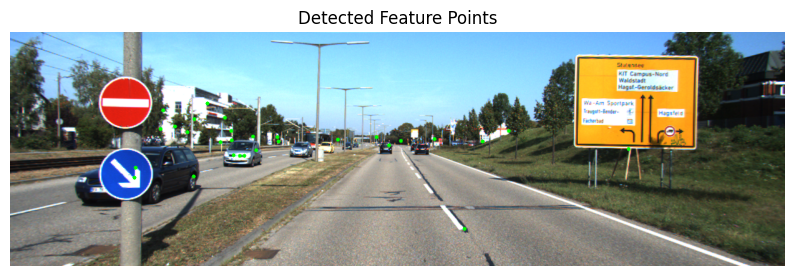

In [6]:
# Shi-Tomasi corner detector parameters
feature_params = dict(
    maxCorners=200,      
    qualityLevel=0.6,     
    minDistance=6,        
    blockSize=3           
)

# Detect corners in the first image
corners = cv2.goodFeaturesToTrack(gray1, mask=None, **feature_params)

# Create a copy of the image 
vis_img = img1.copy()

# Draw circles at corner points
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(vis_img, (int(x), int(y)), 3, (0, 255, 0), -1)

# Display the image with corners
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title('Detected Feature Points')
plt.axis('off')
plt.show()

In [ ]:
print("what")